In [9]:
import numpy as np
import pywt
import os
import math
import cv2
from PIL import Image
from scipy.fftpack import dct
from scipy.fftpack import idct
from matplotlib import pyplot as plt
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

In [10]:
import skimage
# image=skimage.data.camera()
image=cv2.imread('/content/drive/MyDrive/dataset/lena.jpg')

In [11]:
# watermark=cv2.imread('/content/drive/MyDrive/dataset/.jpg')
watermark=skimage.data.camera()

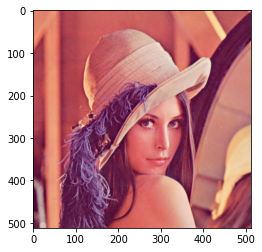

In [12]:
import matplotlib.pyplot as plt
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

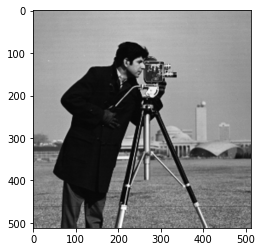

In [13]:
plt.imshow(watermark,cmap='gray')

In [14]:
print(image.shape)
print(watermark.shape)

(512, 512, 3)
(512, 512)


In [15]:
def image_resize(image_name, size):
    img = Image.fromarray(image_name).resize((size, size), 1)
    img_gray = img.convert('L')
    img_rgb = img.convert('RGB')
    image_name2 = 'rgb_'+str(image_name)
    # img_gray.save('./dataset/' + image_name)
    # img_rgb.save('./dataset/' + image_name2)

 
    image_array = np.array(img_gray, dtype=np.float).reshape((size, size))
    image_array_rgb = np.array(img_rgb, dtype=np.float).reshape((size, size,3))    

    return img, image_array, image_array_rgb

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
def mul_wavelet_dec(imArray):
    shape = imArray.shape
    fig, axes = plt.subplots(2, 4, figsize=[14, 8])
    max_lev = 3       # how many levels of decomposition to draw
    label_levels = 3  # how many levels to explicitly label on the plots
    for level in range(0, max_lev + 1):
        if level == 0:
            # show the original image before decomposition
            axes[0, 0].set_axis_off()
            axes[1, 0].imshow(imArray, cmap=plt.cm.gray)
            axes[1, 0].set_title('Image')
            axes[1, 0].set_axis_off()
            continue

        # plot subband boundaries of a standard DWT basis
        draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                         label_levels=label_levels)
        axes[0, level].set_title('{} level\ndecomposition'.format(level))

        # compute the 2D DWT
        c = pywt.wavedec2(imArray, 'haar', mode='periodization', level=level)
        # normalize each coefficient array independently for better visibility
        c[0] /= np.abs(c[0]).max()
        for detail_level in range(level):
            c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
        # show the normalized coefficients
        arr, slices = pywt.coeffs_to_array(c)
        axes[1, level].imshow(arr, cmap=plt.cm.gray)
        axes[1, level].set_title('Coefficients\n({} level)'.format(level))
        axes[1, level].set_axis_off()

In [18]:
def process_coefficients(imArray, model, level):
    
    coeffs=pywt.wavedec2(data = imArray, wavelet = model, level = level)
    coeffs_H=list(coeffs) 
   
    return coeffs_H

In [19]:
def apply_dct(image_array):
    size = image_array[0].__len__()
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct

In [20]:
def inverse_dct(all_subdct):
    size = all_subdct[0].__len__()
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct

    return all_subidct

In [66]:
def embed_watermark(watermark_array, orig_image):
    orig_image_dummy = orig_image
    watermark_array_size = watermark_array[0].__len__()
    watermark_flat = watermark_array.ravel()
    ind = 0
    
    for x in range (0, orig_image.__len__(), 8):
        for y in range (0, orig_image.__len__(), 8):
            if ind < watermark_flat.__len__():
                subdct = orig_image[x:x+8, y:y+8]
                subdct[2][2] = 0.09*watermark_flat[ind]
                orig_image_dummy[x:x+8, y:y+8] = subdct
                ind += 1 


    return orig_image_dummy
    

In [22]:
def print_image_from_array(image_array):
  
    image_array_copy = image_array.clip(0, 255)
    image_array_copy = image_array_copy.astype("uint8")
    img = Image.fromarray(image_array_copy)
    # img.save('./result/' + name)
    return img

In [132]:
def get_watermark(dct_watermarked_coeff, watermark_size):
    
    subwatermarks = []

    for x in range (0, dct_watermarked_coeff.__len__(), 8):
        for y in range (0, dct_watermarked_coeff.__len__(), 8):
            coeff_slice = dct_watermarked_coeff[x:x+8, y:y+8]
            subwatermarks.append(coeff_slice[2][2])
            
    watermark = np.array(subwatermarks).reshape(watermark_size, watermark_size)*255
    # watermark = np.array(subwatermarks)*255

    return watermark

def recover_watermark(image_array, model, level, wm_size):


    coeffs_watermarked_image = process_coefficients(image_array, model, level=level)
    coeffs_watermarked_image_l2 = process_coefficients(coeffs_watermarked_image[1][0], model, level=level)
    dct_watermarked_coeff = apply_dct(coeffs_watermarked_image_l2[0])
    
    watermark_array = get_watermark(dct_watermarked_coeff, wm_size)

    watermark_array =  np.uint8(watermark_array)

    #Save result
    img = Image.fromarray(watermark_array)
    # img.convert('RGB')
    # r = img.split()
    # img = img.point(lambda i: i * 10)
    # g = g.point(lambda i: i * 100)
    # b = b.point(lambda i: i * 100)
    # out = Image.merge('RGB', (r, g,B))
    # img = Image.fromarray(out)
    return img
    # img.save('./result/recovered_watermark.bmp')

(2048, 2048, 3)


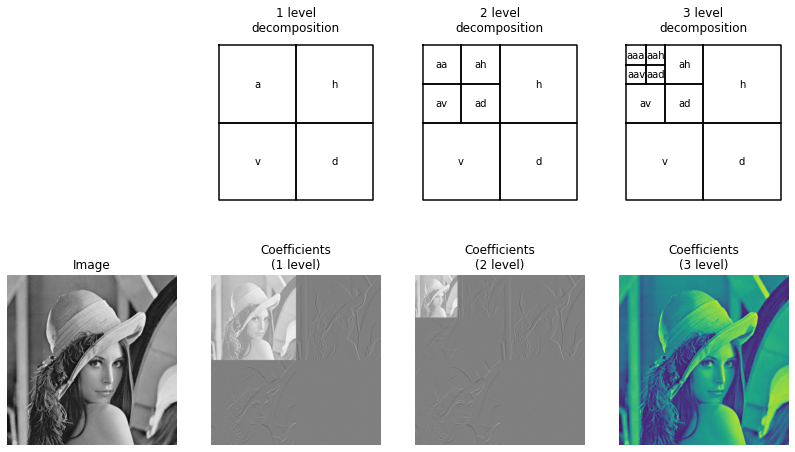

In [128]:
model = 'haar'
level = 1
wm_size = 64
ori_img, image_array, image_array_rgb = image_resize(image, 2048)

mul_wavelet_dec(image_array)
plt.imshow(image_array)
print(np.array(ori_img).shape)

In [64]:
def embedd_and_psnr(imgage_array_rgb,ori_img,image_array):
  coeffs_image = process_coefficients(image_array_rgb[:,:,2], model, level=level)
  coeffs_image_l2 = process_coefficients(coeffs_image[1][0], model, level=level)
  before_wm = apply_dct(coeffs_image_l2[0])
  ori_wm, watermark_array, watermark_rgb = image_resize(watermark, wm_size)
  watermark_array = watermark_array/255
  after_wm = embed_watermark(watermark_array, before_wm)
  coeffs_image_l2_temp = coeffs_image_l2
  coeffs_image_l2_temp[0][:][:] = inverse_dct(after_wm)
  temp = pywt.waverec2(coeffs_image_l2_temp, model)
  coeffs_image_l1_temp = coeffs_image
  coeffs_image_l1_temp[1][0][:][:] = temp
  image_array_H=pywt.waverec2(coeffs_image_l1_temp, model)
  #rgb formulate 
  image_wm_array_rgb = np.zeros((2048,2048,3))
  image_wm_array_rgb[:,:,2] = image_array_H
  image_wm_array_rgb[:,:,0] = image_array_rgb[:,:,0]
  image_wm_array_rgb[:,:,1] = image_array_rgb[:,:,1]
  img_with_wm = print_image_from_array(image_wm_array_rgb)
  fig, axes = plt.subplots(1, 2, figsize=[18, 10])
  axes[0].imshow(ori_img)
  axes[0].set_title("Image with Watermark")
  axes[0].set_axis_off()

  axes[1].imshow(img_with_wm)
  axes[1].set_title("Original Image")
  axes[1].set_axis_off()
  extracted_wm=recover_watermark(image_array = image_array_H, model=model, level = level, wm_size=wm_size)
  extracted_wm = extracted_wm.resize((128, 128), 1)
  extracted_wm = extracted_wm.convert('RGB')
  fig, axes = plt.subplots(1, 2, figsize=[10, 5])
  axes[0].imshow(extracted_wm)
  axes[0].set_title("Extracted Watermark")
  axes[0].set_axis_off()

  axes[1].imshow(ori_wm)
  axes[1].set_title("Original Watermark")
  axes[1].set_axis_off()
  
# def psnr(img1, img2):
#     mse = np.mean( (img1 - img2) ** 2 )
#     if mse == 0:
#         return 100
#     PIXEL_MAX = 255.0
#     return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))   

  d = psnr(image_array_rgb,image_wm_array_rgb)
  print(d)
  # return ori_img

In [26]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse)) 

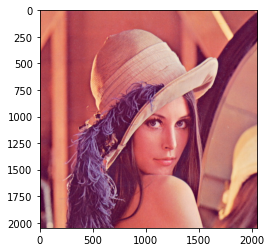

In [27]:
ori_image=np.array(ori_img)
plt.imshow(ori_image,cmap='gray')

66.89164802480563


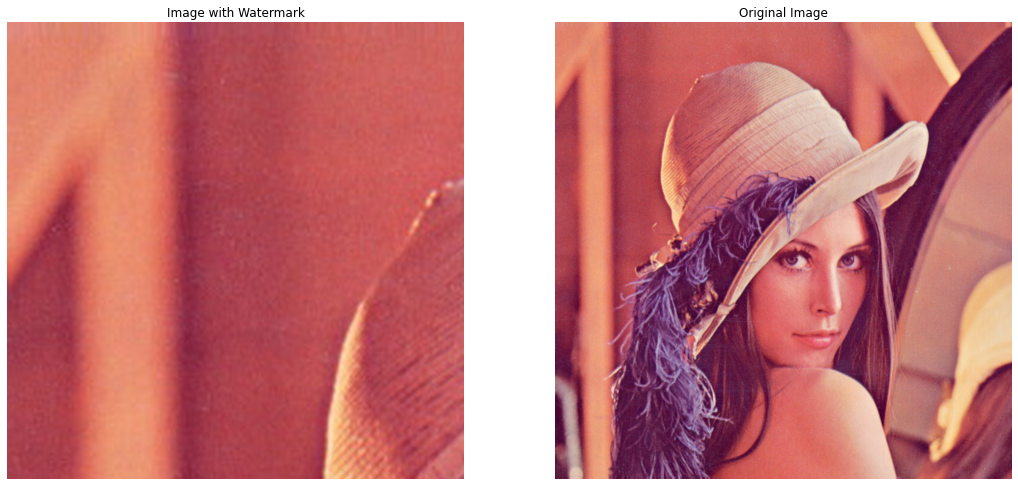

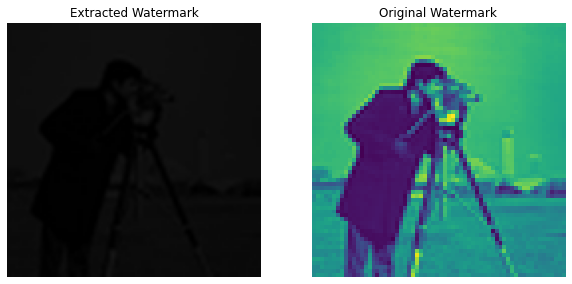

In [133]:
img1=image_array_rgb[0:683,0:683,:]
img1_ori=ori_image[0:683,0:683,:]
img1_=image_array[0:683,0:683]
embedd_and_psnr(img1,img1_ori,img1_)

66.89164802480563


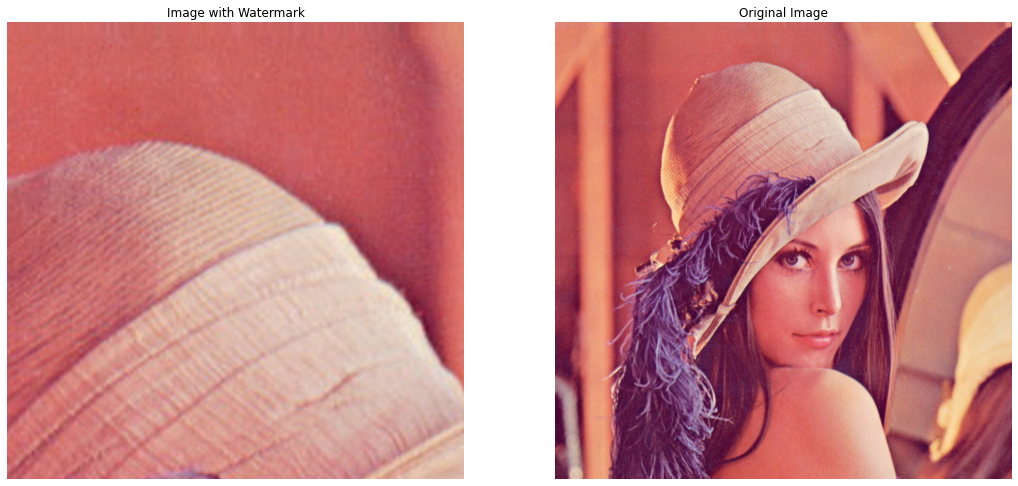

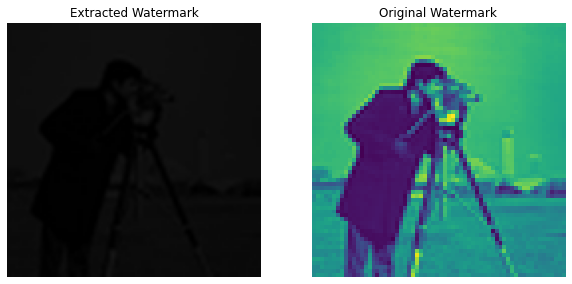

In [134]:
img2=image_array_rgb[0:683,683:1366,:]
img2_ori=ori_image[0:683,683:1366,:]
img2_=image_array[0:683,1366:2048]
embedd_and_psnr(img2,img2_ori,img2_)
# img1.shape

66.89164802480563


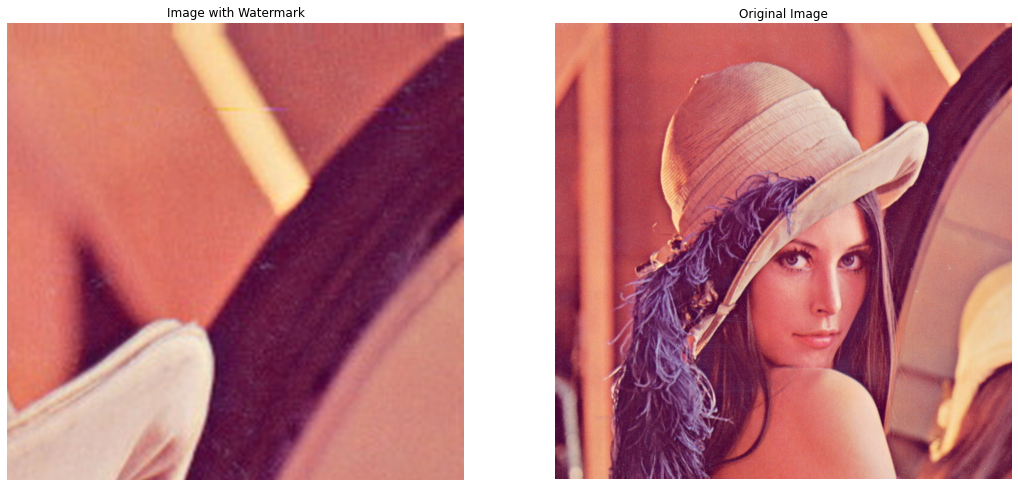

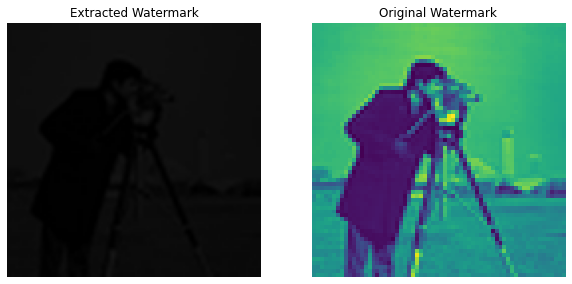

In [135]:
img3=image_array_rgb[0:683,1366:2048,:]
img3_ori=ori_image[0:683,1366:2048,:]
img3_=image_array[0:683,1366:2048]
embedd_and_psnr(img3,img3_ori,img3_)
# img1.shape

66.89164802480563


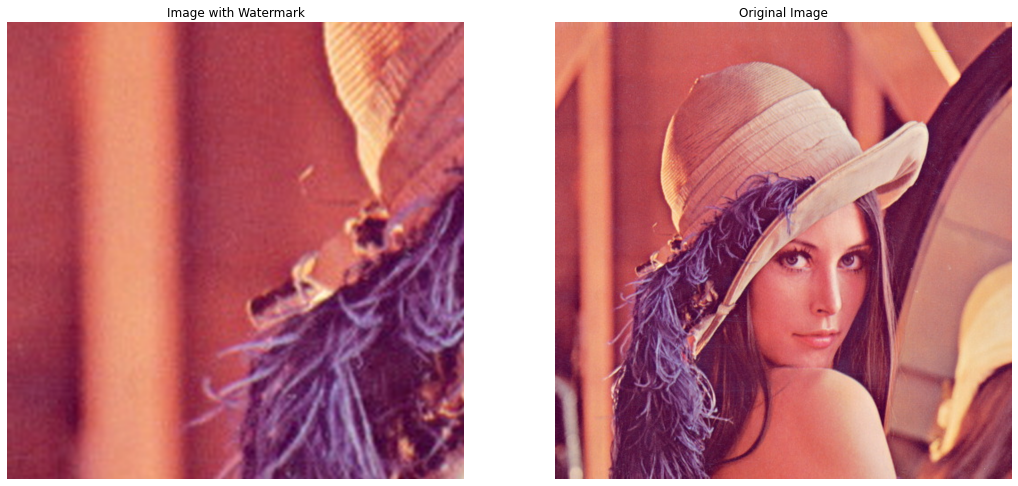

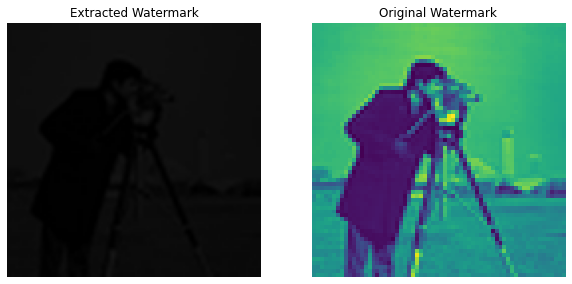

In [136]:
img4=image_array_rgb[683:1366,0:683,:]
img4_ori=ori_image[683:1366,0:683,:]
img4_=image_array[683:1366,0:683]
embedd_and_psnr(img4,img4_ori,img4_)

66.89164802480563


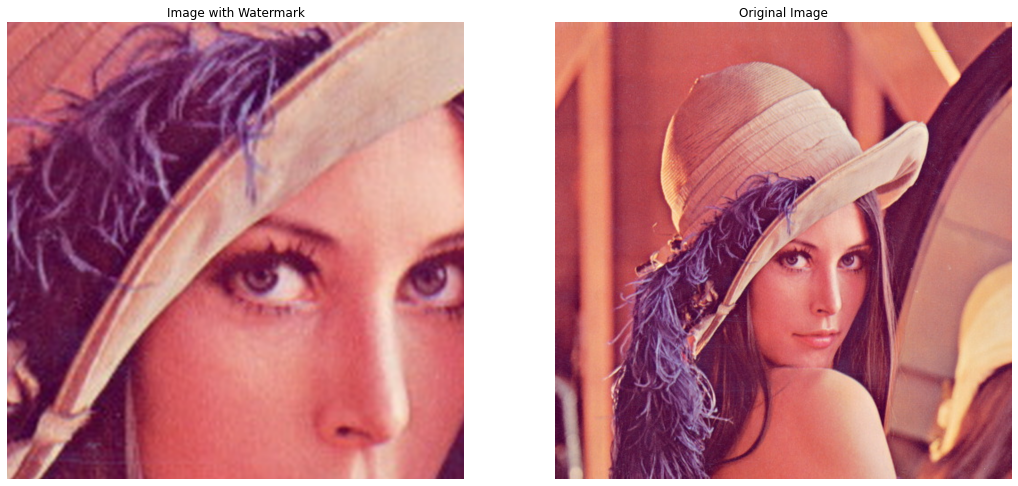

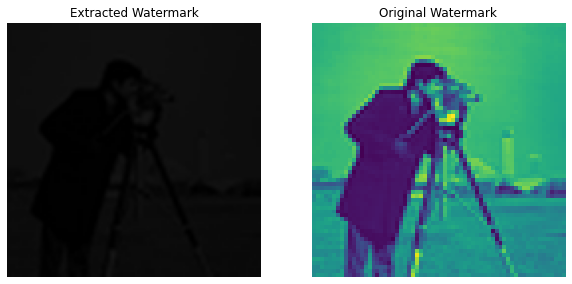

In [137]:
img5=image_array_rgb[683:1366,683:1366,:]
img5_ori=ori_image[683:1366,683:1366,:]
img5_=image_array[683:1366,683:1366]
embedd_and_psnr(img5,img5_ori,img5_)

66.89164802480563


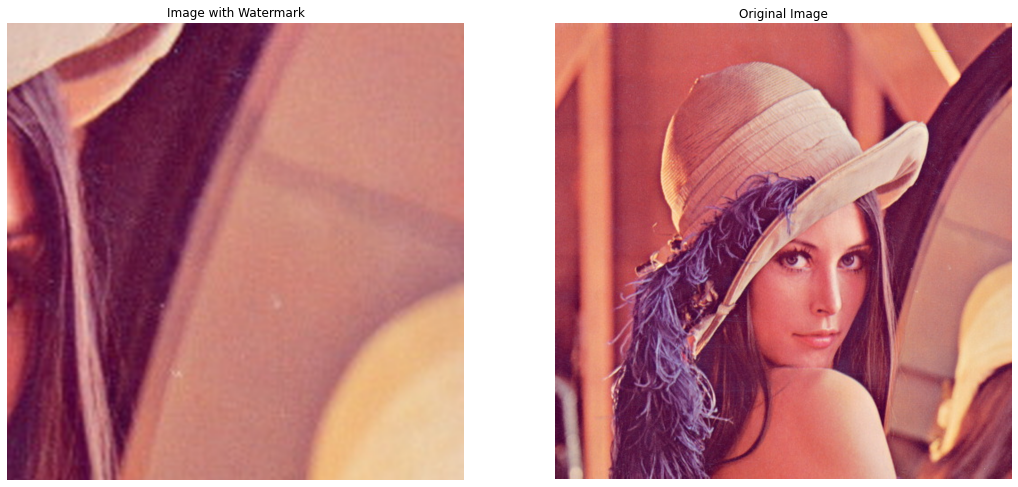

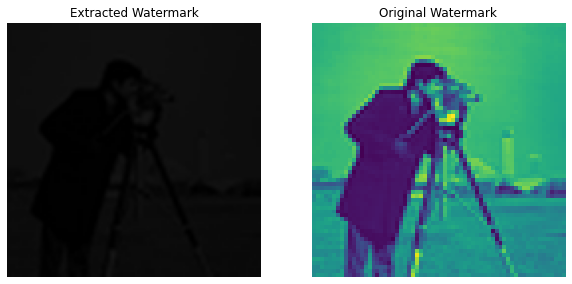

In [138]:
img6=image_array_rgb[683:1366,1366:2048,:]
img6_ori=ori_image[683:1366,1366:2048,:]
img6_=image_array[683:1366,1366:2048]
embedd_and_psnr(img6,img6_ori,img6_)

66.89164802480563


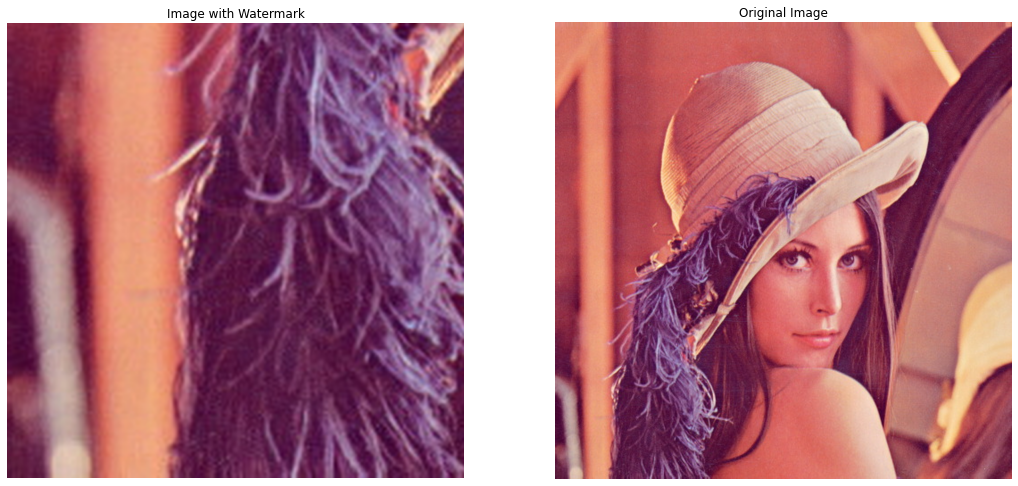

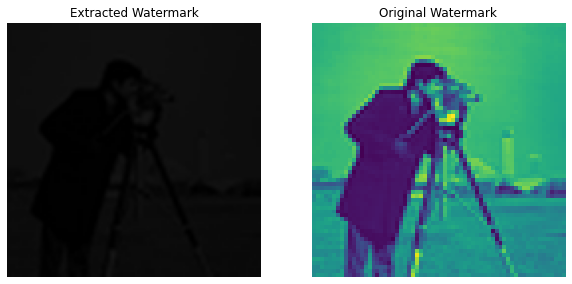

In [139]:
img7=image_array_rgb[1366:2048,0:683,:]
img7_ori=ori_image[1366:2048,0:683,:]
img7_=image_array[1366:2048,0:683]
embedd_and_psnr(img7,img7_ori,img7_)

66.89164802480563


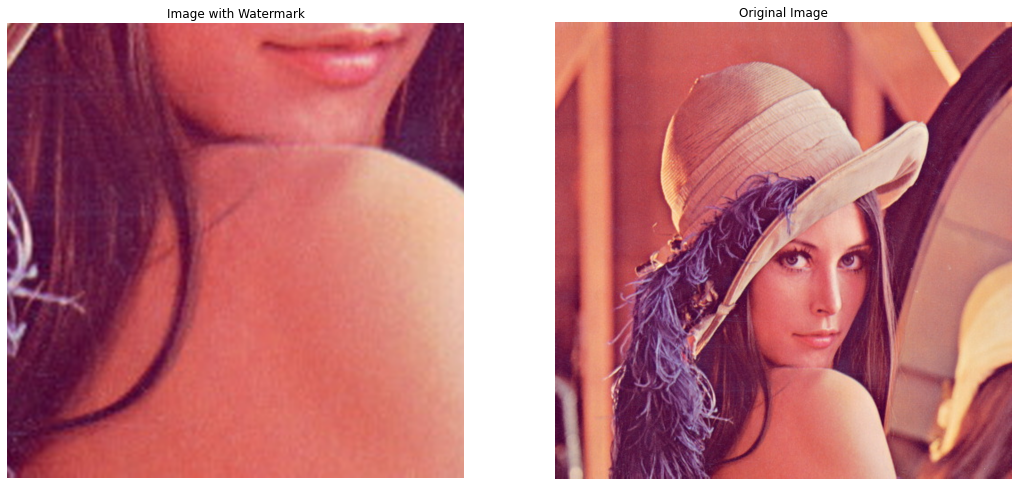

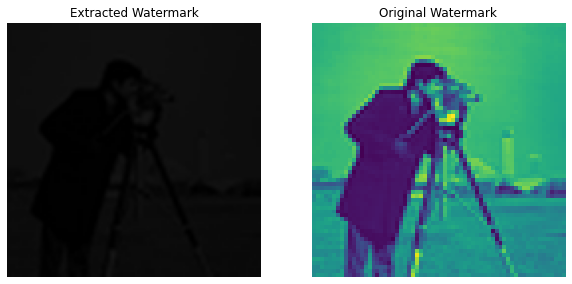

In [140]:
img8=image_array_rgb[1366:2048,683:1366,:]
img8_ori=ori_image[1366:2048,683:1366,:]
img8_=image_array[1366:2048,683:1366]
embedd_and_psnr(img8,img8_ori,img8_)

66.89164802480563


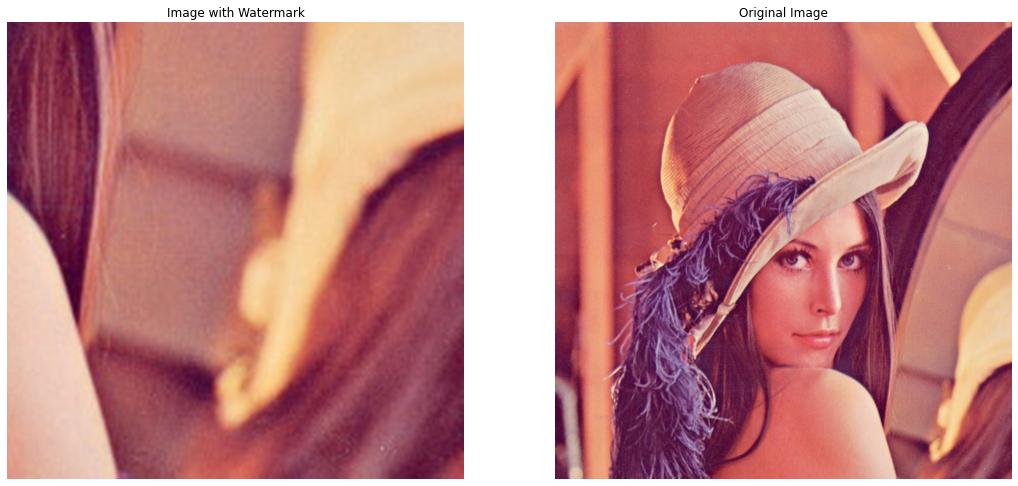

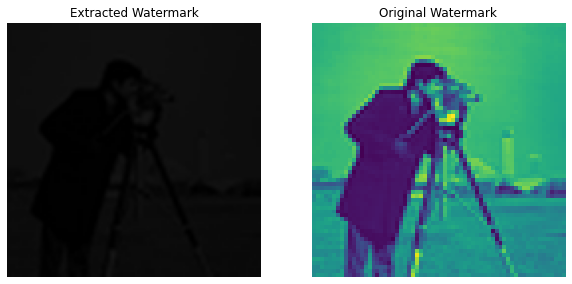

In [141]:
img9=image_array_rgb[1366:2048,1366:2048,:]
img9_ori=ori_image[1366:2048,1366:2048,:]
img9_=image_array[1366:2048,1366:2048]
embedd_and_psnr(img9,img9_ori,img9_)

In [142]:
img1

array([[[225., 138., 128.],
        [225., 138., 128.],
        [225., 138., 128.],
        ...,
        [209.,  99.,  98.],
        [209.,  99.,  98.],
        [209.,  99.,  98.]],

       [[225., 138., 128.],
        [225., 138., 128.],
        [225., 138., 128.],
        ...,
        [209.,  99.,  98.],
        [209.,  99.,  98.],
        [209.,  99.,  98.]],

       [[225., 138., 128.],
        [225., 138., 128.],
        [225., 138., 128.],
        ...,
        [209.,  99.,  98.],
        [209.,  99.,  98.],
        [209.,  99.,  98.]],

       ...,

       [[167.,  63.,  77.],
        [166.,  62.,  76.],
        [166.,  62.,  76.],
        ...,
        [176.,  82.,  92.],
        [174.,  81.,  91.],
        [174.,  81.,  90.]],

       [[166.,  61.,  76.],
        [166.,  61.,  75.],
        [166.,  61.,  75.],
        ...,
        [170.,  77.,  88.],
        [169.,  76.,  87.],
        [170.,  77.,  87.]],

       [[166.,  61.,  75.],
        [166.,  61.,  75.],
        [166.,  

In [143]:
def printSpiralOrder(mat):
 
    top = left = z=0
    bottom = len(mat) - 1
    right = len(mat[0]) - 1
    portion1=np.array(np.zeros((683*683*3,1)))
    while True:
        if left > right:
            break
 
        # print top row
        for i in range(left, right + 1):
            # print(mat[top][i], end=' ')
            portion1[z]=mat[top][i][0]
            z=z+3
        top = top + 1
 
        if top > bottom:
            break
 
        # print right column
        for i in range(top, bottom + 1):
            # print(mat[i][right], end=' ')
            portion1[z]=mat[i][right][0]
            z=z+3
        right = right - 1
 
        if left > right:
            break
 
        # print bottom row
        for i in range(right, left - 1, -1):
            # print(mat[bottom][i], end=' ')
            portion1[z]=mat[bottom][i][0]
            z=z+3
        bottom = bottom - 1
 
        if top > bottom:
            break
 
        # print left column
        for i in range(bottom, top - 1, -1):
            # print(mat[i][left], end=' ')
            portion1[z]=mat[i][left][0]
            z=z+3
        left = left + 1
    return portion1


In [144]:

# # Function Call
portion1=np.array(np.zeros((683*683,1)))
portion1=printSpiralOrder(img1)

# # Function Call
portion2=np.array(np.zeros((683*683,1)))
portion2=printSpiralOrder(img2)

# # Function Call
portion3=np.array(np.zeros((683*683,1)))
portion3=printSpiralOrder(img3)

# # Function Call
portion4=np.array(np.zeros((683*683,1)))
portion4=printSpiralOrder(img4)

# # Function Call
portion5=np.array(np.zeros((683*683,1)))
portion5=printSpiralOrder(img5)

# # Function Call
portion6=np.array(np.zeros((683*683,1)))
portion6=printSpiralOrder(img6)

# # Function Call
portion7=np.array(np.zeros((683*683,1)))
portion7=printSpiralOrder(img7)
# # Function Call
portion8=np.array(np.zeros((683*683,1)))
portion8=printSpiralOrder(img8)

# # Function Call
portion9=np.array(np.zeros((683*683,1)))
portion9=printSpiralOrder(img9)


In [145]:
portion1.resize(683,683)
portion2.resize(683,683)
portion3.resize(683,683)
portion4.resize(683,683)
portion5.resize(683,683)
portion6.resize(683,683)
portion7.resize(683,683)
portion8.resize(683,683)
portion9.resize(683,683)

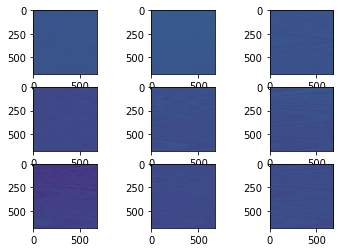

In [162]:
plt.subplot(3,3,1)
plt.imshow(portion1)
plt.subplot(3,3,2)
plt.imshow(portion2)
plt.subplot(3,3,3)
plt.imshow(portion3)
plt.subplot(3,3,4)
plt.imshow(portion4)
plt.subplot(3,3,5)
plt.imshow(portion5)
plt.subplot(3,3,6)
plt.imshow(portion6)
plt.subplot(3,3,7)
plt.imshow(portion7)
plt.subplot(3,3,8)
plt.imshow(portion8)
plt.subplot(3,3,9)
plt.imshow(portion9)


In [146]:
original=np.array(np.zeros((2048,2048)))

In [147]:
# 0.2989 * r + 0.5870 * g + 0.1140 * b
original[0:683,0:683]=img1[:,:,0]*0.2989+img1[:,:,1]*0.5870+img1[:,:,2]*0.1140

In [148]:
original[0:683,683:1366]=img2[:,:,0]*0.2989+img2[:,:,1]*0.5870+img2[:,:,2]*0.1140

In [149]:
original[0:683,1366:2048]=img3[:,:,0]*0.2989+img3[:,:,1]*0.5870+img3[:,:,2]*0.1140

In [150]:
original[683:1366,0:683]=img4[:,:,0]*0.2989+img4[:,:,1]*0.5870+img4[:,:,2]*0.1140

In [151]:
original[683:1366,683:1366]=img5[:,:,0]*0.2989+img5[:,:,1]*0.5870+img5[:,:,2]*0.1140

In [152]:
original[683:1366,1366:2048]=img6[:,:,0]*0.2989+img6[:,:,1]*0.5870+img6[:,:,2]*0.1140

In [153]:
original[1366:2048,0:683]=img7[:,:,0]*0.2989+img7[:,:,1]*0.5870+img7[:,:,2]*0.1140

In [154]:
original[1366:2048,683:1366]=img8[:,:,0]*0.2989+img8[:,:,1]*0.5870+img8[:,:,2]*0.1140

In [155]:
original[1366:2048,1366:2048]=img9[:,:,0]*0.2989+img9[:,:,1]*0.5870+img9[:,:,2]*0.1140

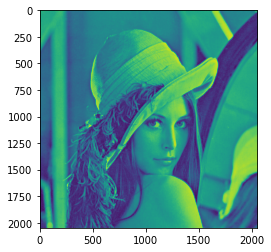

In [156]:
plt.imshow(original)

In [158]:
# image_array_rgb=image_array_rgb[:,:,0]*0.2989+image_array_rgb[:,:,1]*0.5870+image_array_rgb[:,:,2]*0.1140
d = psnr(image_array_rgb,original)
print(d)

100
